# Fine tuning with S-BERT

### Instructions to run this notebook

#### These are the sections in this notebook. Please read the notes below to avoid any errors.

1. [Setup](#setup) - Install the necessary libraries, the GitHub repository, and import the code from the repository.
2. [Data Loading](#data-loading) - Define your **GLOBAL_EXPERIMENT_NUMBER** carefully so that it doesn't overwrite another folder on Google Drive. Running this section will produce the data distriibution for the binary/multiclass classification dataset. A good visual check to see if the number of examples in the classes are roughly equal and well distributes in the training and test datasets. This section also makes sure that the training sentences and labels are available to the Python scripts from the GitHub repository to fine-tune the model.
3. [Configuring W&B credentials and Run](#wandb-config) - The most importany part of this section is to insert your WANDB_API_KEY in the key variable. This will make sure that you can submit your run to the common Weights&Biases project. The WANDB_RUN_GROUP and WANDB_JOB_TYPE variables can be set as well. These 2 variables help in filtering multiple runs of the same or similar hyperparameter configuring for better readability on the Weights&Biases dashboard.
4. [Grid Search Fine Tuning - W&B sweeps](#wandb-sweep) - In this section we define the Weights&Biases hyperparameter sweep. The method of the sweep defines how the automatic tuning will happen (random is the easiest way). If we use the random method, we have to specify the ``count`` parameter later on to tell wandb how many random subsets are to be taken when running the sweep. You can also specify the name of the sweep in this sweep_config. Another important part is to define the maximizing factor, right now in our case it is the ``Weighted F1 validation`` score. **Note**, the maximizing factor in the metrics needs to be a value that we are loggings with wandb (wandb.log), the string needs to match exactly. In the hyperparameter dictionary of the sweep is where we list the multiple values of each hyperparameter that we wish to fine-tune. If the key ``values`` is used, wandb expects a list of values for that hyperparameter, if the key is ``value`` there should only be one value. In this way we can specify constant hyperparameters as well. 
5. [Running training function for only one run](#single-run) - In the scenario where we push to only submit a single run to Weights&Biases, we can use this section to run another training function with **one set of hyperparameter values**. **Note** that this section still requires the WANDB_API_KEY to be set in the [Configuring W&B credentials and Run](#wandb-config) section as well as the run group if it is required.
6. [Removing the saving directory from Google Drive](#delete-folder) - While fine-tuning we save the model in the Google Drive in the GLOBAL_EXPERIMENT_NUMBER folder. After the model is successfully saved onto the Weights&Biases run, we can safely delete the folder from Google Drive to save storage space.
7. [Loading saved model](#load-model) - We can load the model saved in the single run fine-tuning section. The run id is already saved in a variable which is how wandb finds the ``saved_model.pt`` file. If you wish to retrieve a model from a sweep, you need to find the run id from the online dashboard of the best run and use it in this section.
8. [Testing model on test set](#test-set) - In this section we get a realistic performance of the saved model on the test set.

<a name="setup"></a>
## Setup

In [ ]:
# !pip install --quiet --upgrade urllib3

In [ ]:
# Install necessary libraries
! pip install --quiet \
  scprep\
  spacy==3.0.5 \
  ipywidgets \
  qiskit \
  wandb \
  huggingface-hub==0.0.12 \
  -U sentence-transformers \
  phate==1.0.7 && \
  python -m spacy download es_core_news_lg \
  boto3
  # Restarting the runtime is required for the libraries to be active in the notebook
import os
os.kill(os.getpid(), 9)

     |████████████████████████████████| 133kB 14.1MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
2021-06-29 14:37:57.084850: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_lg')


In [ ]:
import spacy
if spacy.prefer_gpu():
    print("Using the GPU")
else:
    print("Using the CPU")
es_nlp = spacy.load('es_core_news_lg')

Using the GPU


In [ ]:
# Setup connection with your own google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Clone branch from github
!rm -rf policy-data-analyzer/
!branch_name='hssc' && \
  git clone --branch $branch_name https://github.com/wri-dssg/policy-data-analyzer.git

Cloning into 'policy-data-analyzer'...
remote: Enumerating objects: 6785, done.
remote: Counting objects: 100% (851/851), done.
remote: Compressing objects: 100% (550/550), done.
remote: Total 6785 (delta 580), reused 535 (delta 299), pack-reused 5934
Receiving objects: 100% (6785/6785), 209.81 MiB | 8.40 MiB/s, done.
Resolving deltas: 100% (3807/3807), done.
Checking out files: 100% (1009/1009), done.


In [ ]:
#If you run this cell more than once, comment out this line because you are already in this folder and you will get an error
import os
os.chdir("policy-data-analyzer") 

# from tasks.fine_tuning_sbert.src.loops import *

In [ ]:
import csv
import math
import wandb
import time
import transformers
from pathlib import Path
# import os
import random
import subprocess
from typing import Iterable, Dict

import cupy as cp
# import spacy
import torch
from sentence_transformers import SentencesDataset, SentenceTransformer, InputExample
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from torch import nn, Tensor
from torch.utils.data import DataLoader

from tasks.data_augmentation.src.zero_shot_classification.latent_embeddings_classifier import *
from tasks.data_loading.src.utils import *
from tasks.data_visualization.src.plotting import *
# from tasks.fine_tuning_sbert.src.sentence_transformer import EarlyStoppingSentenceTransformer
from tasks.fine_tuning_sbert.src.custom_evaluator import CustomLabelAccuracyEvaluator
from tasks.model_evaluation.src.model_evaluator import *

# if spacy.prefer_gpu():
#     print("Using the GPU")
# else:
#     print("Using the CPU")

In [ ]:
class SoftmaxClassifier(nn.Module):
    """
    This loss adds a softmax classifier on top of the output of the transformer network.
    It takes a sentence embedding and learns a mapping between it and the corresponding category.
    :param model: SentenceTransformer model
    :param sentence_embedding_dimension: Dimension of your sentence embeddings
    :param num_labels: Number of different labels
    """

    def __init__(self,
                 model: SentenceTransformer,
                 sentence_embedding_dimension: int,
                 num_labels: int):
        super(SoftmaxClassifier, self).__init__()
        self.model = model
        self.num_labels = num_labels
        self.classifier = nn.Linear(sentence_embedding_dimension, num_labels)

    def forward(self, sentence_features: Iterable[Dict[str, Tensor]], labels: Tensor):
        # Get batch sentence embeddings
        features = self.model(sentence_features[0])['sentence_embedding']

        # Get batch loss
        output = self.classifier(features)
        loss_fct = nn.CrossEntropyLoss()

        if labels is not None:
            loss = loss_fct(output, labels.view(-1))
            return loss
        else:
            return features, output

In [ ]:
def single_run_fine_tune_HSSC(train_params, train_sents, train_labels, label_names):
    """
    Find the optimal SBERT model by doing a hyperparameter search over random seeds, dev percentage, and different types of SBERT models
    """
    output_path = train_params["output_path"]
    dev_perc = train_params["all_dev_perc"]
    model_name = train_params["model_names"]
    max_num_epochs = train_params["max_num_epochs"]
    group_name = train_params["group_name"]

    print(f"Fine tuning parameters:\n{json.dumps(train_params, indent=4)}")

    # Load base model
    model = SentenceTransformer(model_name)
    # Splitting training and validation datasets
    label2int = dict(zip(label_names, range(len(label_names))))
    X_train, X_dev, y_train, y_dev = train_test_split(train_sents, train_labels, test_size=dev_perc,
                                                      stratify=train_labels, random_state=100)
    print("\n This is the length of the training set:", len(X_train))
    # Load data samples into batches
    train_batch_size = 16
    train_samples = build_data_samples(X_train, label2int, y_train)
    dev_samples = build_data_samples(X_dev, label2int, y_dev)

    # Train set config
    # train_dataset = SentencesDataset(train_samples, model=model)
    train_dataloader = DataLoader(
        train_samples, shuffle=True, batch_size=train_batch_size, num_workers=0,pin_memory=False, generator=torch.Generator(device='cuda'))

    # Dev set config
    # dev_dataset = SentencesDataset(dev_samples, model=model)
    dev_dataloader = DataLoader(
        dev_samples, shuffle=True, batch_size=train_batch_size, num_workers=0,pin_memory=False, generator=torch.Generator(device='cuda'))

    # Define the way the loss is computed
    classifier = SoftmaxClassifier(model=model,
                                   sentence_embedding_dimension=model.get_sentence_embedding_dimension(),
                                   num_labels=len(label2int))
    warmup_steps = math.ceil(
        len(train_samples) * max_num_epochs / train_batch_size * 0.1)  # 10% of train data for warm-up

    # Train the model
    start = time.time()
    dev_evaluator = CustomLabelAccuracyEvaluator(dataloader=dev_dataloader, softmax_model=classifier,
                                                 name='lae-dev', label_names=label_names)

    # Init WandB
    # wandb.init(project='HSSC', group=group_name, entity='jordi_planas')

    model.fit(train_objectives=[(train_dataloader, classifier)],
              evaluator=dev_evaluator,
              epochs=max_num_epochs,
              evaluation_steps=1000,
              warmup_steps=warmup_steps,
              output_path=output_path
              # show_progress_bar=False
              )

    if output_path != None:
        torch.save(model, output_path+'/saved_model.pt')
        # wandb.save(output_path+'/saved_model.pt')
        # wandb.finish()

    # else:
        # wandb.finish()

    return model


def make_dataset_public(train_sents_, train_labels_, label_names_):
    global train_sents, train_labels, label_names
    train_sents = train_sents_
    train_labels = train_labels_
    label_names = label_names_


def build_data_samples(X_train, label2int, y_train):
    train_samples = []
    for sent, label in zip(X_train, y_train):
        label_id = label2int[label]
        train_samples.append(InputExample(texts=[sent], label=label_id))
    return train_samples

def evaluate_using_sklearn(clf, model, train_sents, train_labels, test_sents, test_labels, label_names):
    """
    Evaluate an S-BERT model on a previously unseen test set, visualizing the embeddings, confusion matrix,
    and returning. Evaluation method:
     - A sklearn classifier, such as a RandomForest or SVM
    """
    # Sentence encoding
    print("Classifying sentences...")
    train_embs = encode_all_sents(train_sents, model)
    test_embs = encode_all_sents(test_sents, model)

    # Classifier training
    clf.fit(np.vstack(train_embs), train_labels)

    # Classifier predictions
    clf_preds = list(clf.predict(np.vstack(test_embs)))

    print("Evaluating predictions...")
    print(classification_report(test_labels, clf_preds))
    numeric_preds = labels2numeric(clf_preds, label_names)
    numeric_test_labels = labels2numeric(test_labels, label_names)
    evaluator = ModelEvaluator(
        label_names, y_true=numeric_test_labels, y_pred=numeric_preds)

    visualize_embeddings_2D(np.vstack(test_embs), test_labels, tsne_perplexity=50)
    evaluator.plot_confusion_matrix(color_map='Blues')
    print("Macro/Weighted Avg F1-score:", evaluator.avg_f1.tolist())

    return evaluator.avg_f1.tolist()

<a name="data-loading"></a>
## Experiment setup and run

In [ ]:
'''
PASTE YOUR WEIGHTS & BIASES KEY HERE
Please do not forget to delete the key after finishing using the notebook. Or simply don't save the notebook to GitHub or Google Drive :)
If the key is compromised you can always make a new one in your W&B settings and remove the old one :)
'''

wandb_key = '642c252b516d7d8a8ef2276e7577b5f1b80154c3'
group_desc = ''
job_type = ''

os.environ['WANDB_JOB_TYPE'] = job_type
os.environ['WANDB_RUN_GROUP'] = group_desc
os.environ['WANDB_API_KEY'] = wandb_key

Fine tuning parameters:
{
    "all_dev_perc": 0.2,
    "model_names": "paraphrase-xlm-r-multilingual-v1",
    "output_path": "/content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent/Modeling/HSSC/Results/",
    "max_num_epochs": 10,
    "group_name": "spanish_binary_handpicked"
}

 This is the length of the training set: 448


Evaluating:  38%|███▊      | 3/8 [00:00<00:00, 28.42it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 31.06it/s]


Evaluating:  38%|███▊      | 3/8 [00:00<00:00, 27.04it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 31.78it/s]


Evaluating:  38%|███▊      | 3/8 [00:00<00:00, 26.27it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 30.65it/s]


Evaluating:  38%|███▊      | 3/8 [00:00<00:00, 27.38it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 30.69it/s]


Evaluating:  38%|███▊      | 3/8 [00:00<00:00, 25.92it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 29.76it/s]


Evaluating:  38%|███▊      | 3/8 [00:00<00:00, 25.41it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 28.16it/s]


Evaluating:  38%|███▊      | 3/8 [00:00<00:00, 28.32it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 30.00it/s]


Evaluating:  38%|███▊      | 3/8 [00:00<00:00, 27.67it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 29.40it/s]


Evaluating:  50%|█████     | 4/8 [00:00<00:00, 30.22it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 31.83it/s]


Evaluating:  50%|█████     | 4/8 [00:00<00:00, 29.89it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 31.38it/s]


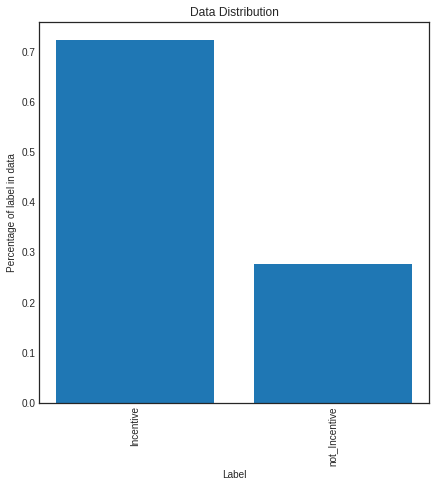

  1%|          | 6/561 [00:00<00:09, 58.35it/s]

Label counts:
{'Incentive': 0.723404255319149, 'not_Incentive': 0.2765957446808511}
spanish_binary_handpicked_handpicked

There are 561 elements in the training dataset 
 There are 141 elements in the test set 

Classifying sentences...


100%|██████████| 141/141 [00:02<00:00, 54.43it/s]


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.85      0.87      0.86       102
not_Incentive       0.64      0.59      0.61        39

     accuracy                           0.79       141
    macro avg       0.74      0.73      0.74       141
 weighted avg       0.79      0.79      0.79       141

Macro/Weighted Avg F1-score: [0.737, 0.792]
\###### [0.737, 0.792] ######

Time taken for fine-tuning: 00:00:15.76


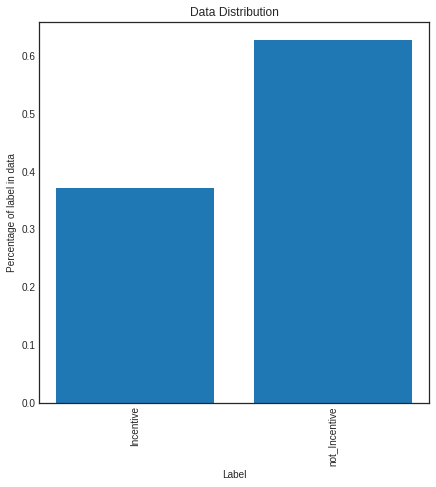

Label counts:
{'Incentive': 0.3723756906077348, 'not_Incentive': 0.6276243093922652}


  0%|          | 0/561 [00:00<?, ?it/s]

spanish_binary_handpicked_assisted

There are 561 elements in the training dataset 
 There are 905 elements in the test set 

Classifying sentences...


100%|██████████| 905/905 [00:14<00:00, 61.68it/s]


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.41      0.96      0.57       337
not_Incentive       0.88      0.16      0.27       568

     accuracy                           0.46       905
    macro avg       0.64      0.56      0.42       905
 weighted avg       0.70      0.46      0.38       905

Macro/Weighted Avg F1-score: [0.422, 0.384]
\###### [0.422, 0.384] ######

Time taken for fine-tuning: 00:00:35.00


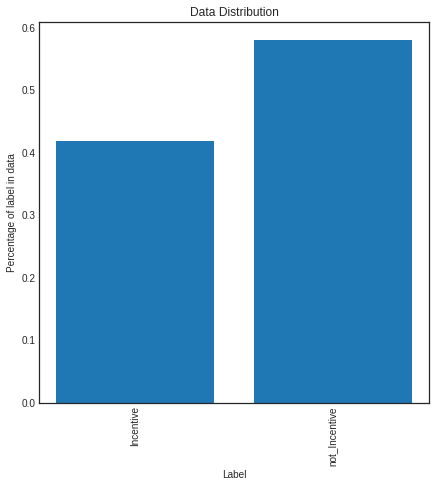

Label counts:
{'Incentive': 0.4196940726577438, 'not_Incentive': 0.5803059273422562}


  1%|          | 7/561 [00:00<00:08, 63.32it/s]

spanish_binary_handpicked_merged

There are 561 elements in the training dataset 
 There are 1046 elements in the test set 

Classifying sentences...


100%|██████████| 1046/1046 [00:16<00:00, 63.00it/s]


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.47      0.96      0.63       439
not_Incentive       0.88      0.20      0.33       607

     accuracy                           0.52      1046
    macro avg       0.67      0.58      0.48      1046
 weighted avg       0.71      0.52      0.46      1046

Macro/Weighted Avg F1-score: [0.48, 0.456]
\###### [0.48, 0.456] ######

Time taken for fine-tuning: 00:00:36.93


_runtime,159
_timestamp,1624984836
_step,21


_runtime,▁▁▂▂▃▃▃▃▃▄▄▅▅▅▅▆▆▆▆███
_timestamp,▁▁▂▂▃▃▃▃▃▄▄▅▅▅▅▆▆▆▆███
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██


Fine tuning parameters:
{
    "all_dev_perc": 0.2,
    "model_names": "paraphrase-xlm-r-multilingual-v1",
    "output_path": "/content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent/Modeling/HSSC/Results/",
    "max_num_epochs": 10,
    "group_name": "spanish_binary_assisted"
}

 This is the length of the training set: 2895


Evaluating:   7%|▋         | 3/46 [00:00<00:01, 28.61it/s]

Evaluating: 100%|██████████| 46/46 [00:01<00:00, 29.74it/s]


Evaluating:   9%|▊         | 4/46 [00:00<00:01, 38.05it/s]

Evaluating: 100%|██████████| 46/46 [00:01<00:00, 29.86it/s]


Evaluating:   9%|▊         | 4/46 [00:00<00:01, 32.40it/s]

Evaluating: 100%|██████████| 46/46 [00:01<00:00, 30.37it/s]


Evaluating:   9%|▊         | 4/46 [00:00<00:01, 34.53it/s]

Evaluating: 100%|██████████| 46/46 [00:01<00:00, 31.32it/s]


Evaluating:   7%|▋         | 3/46 [00:00<00:01, 28.86it/s]

Evaluating: 100%|██████████| 46/46 [00:01<00:00, 29.94it/s]


Evaluating:   9%|▊         | 4/46 [00:00<00:01, 32.02it/s]

Evaluating: 100%|██████████| 46/46 [00:01<00:00, 31.27it/s]


Evaluating:   9%|▊         | 4/46 [00:00<00:01, 32.86it/s]

Evaluating: 100%|██████████| 46/46 [00:01<00:00, 30.49it/s]


Evaluating:   7%|▋         | 3/46 [00:00<00:01, 29.17it/s]

Evaluating: 100%|██████████| 46/46 [00:01<00:00, 30.83it/s]


Evaluating:   9%|▊         | 4/46 [00:00<00:01, 31.39it/s]

Evaluating: 100%|██████████| 46/46 [00:01<00:00, 30.52it/s]


Evaluating:   9%|▊         | 4/46 [00:00<00:01, 37.27it/s]

Evaluating: 100%|██████████| 46/46 [00:01<00:00, 30.52it/s]


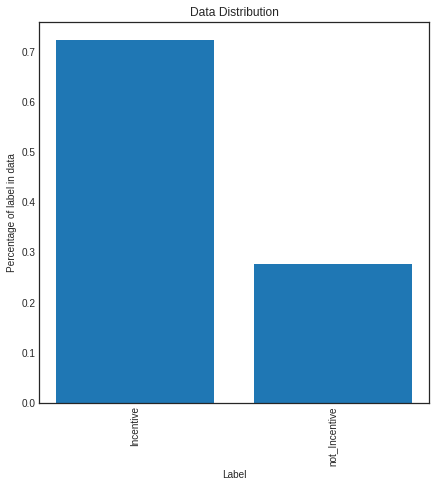

  0%|          | 6/3619 [00:00<01:05, 55.10it/s]

Label counts:
{'Incentive': 0.723404255319149, 'not_Incentive': 0.2765957446808511}
spanish_binary_assisted_handpicked

There are 3619 elements in the training dataset 
 There are 141 elements in the test set 

Classifying sentences...


100%|██████████| 141/141 [00:02<00:00, 62.16it/s]


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.72      0.67      0.69       102
not_Incentive       0.26      0.31      0.28        39

     accuracy                           0.57       141
    macro avg       0.49      0.49      0.49       141
 weighted avg       0.59      0.57      0.58       141

Macro/Weighted Avg F1-score: [0.486, 0.578]
\###### [0.486, 0.578] ######

Time taken for fine-tuning: 00:01:39.48


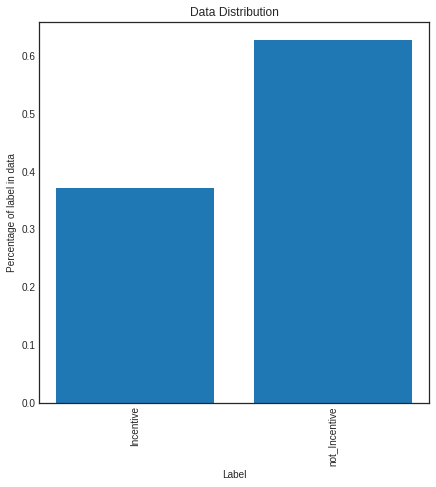

Label counts:
{'Incentive': 0.3723756906077348, 'not_Incentive': 0.6276243093922652}


  0%|          | 6/3619 [00:00<01:04, 56.15it/s]

spanish_binary_assisted_assisted

There are 3619 elements in the training dataset 
 There are 905 elements in the test set 

Classifying sentences...


100%|██████████| 905/905 [00:14<00:00, 62.49it/s]


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.86      0.82      0.84       337
not_Incentive       0.89      0.92      0.91       568

     accuracy                           0.88       905
    macro avg       0.88      0.87      0.87       905
 weighted avg       0.88      0.88      0.88       905

Macro/Weighted Avg F1-score: [0.874, 0.883]
\###### [0.874, 0.883] ######

Time taken for fine-tuning: 00:01:55.49


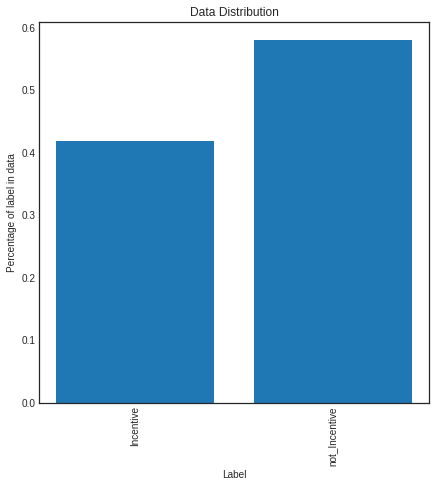

Label counts:
{'Incentive': 0.4196940726577438, 'not_Incentive': 0.5803059273422562}


  0%|          | 7/3619 [00:00<00:54, 65.78it/s]

spanish_binary_assisted_merged

There are 3619 elements in the training dataset 
 There are 1046 elements in the test set 

Classifying sentences...


100%|██████████| 1046/1046 [00:16<00:00, 62.96it/s]


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.90      0.86      0.88       439
not_Incentive       0.90      0.93      0.92       607

     accuracy                           0.90      1046
    macro avg       0.90      0.90      0.90      1046
 weighted avg       0.90      0.90      0.90      1046

Macro/Weighted Avg F1-score: [0.9, 0.903]
\###### [0.9, 0.903] ######

Time taken for fine-tuning: 00:01:57.35


_runtime,620
_timestamp,1624985459
_step,21


_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▇▇▇▇███
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▇▇▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██


Fine tuning parameters:
{
    "all_dev_perc": 0.2,
    "model_names": "paraphrase-xlm-r-multilingual-v1",
    "output_path": "/content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent/Modeling/HSSC/Results/",
    "max_num_epochs": 10,
    "group_name": "spanish_binary_merged"
}

 This is the length of the training set: 3344


Evaluating:   8%|▊         | 4/53 [00:00<00:01, 29.49it/s]

Evaluating: 100%|██████████| 53/53 [00:01<00:00, 30.81it/s]


Evaluating:   8%|▊         | 4/53 [00:00<00:01, 33.46it/s]

Evaluating: 100%|██████████| 53/53 [00:01<00:00, 30.49it/s]


Evaluating:   8%|▊         | 4/53 [00:00<00:01, 29.78it/s]

Evaluating: 100%|██████████| 53/53 [00:01<00:00, 29.93it/s]


Evaluating:   6%|▌         | 3/53 [00:00<00:01, 25.38it/s]

Evaluating: 100%|██████████| 53/53 [00:01<00:00, 29.45it/s]


Evaluating:   8%|▊         | 4/53 [00:00<00:01, 32.25it/s]

Evaluating: 100%|██████████| 53/53 [00:01<00:00, 29.73it/s]


Evaluating:   6%|▌         | 3/53 [00:00<00:01, 25.57it/s]

Evaluating: 100%|██████████| 53/53 [00:01<00:00, 30.69it/s]


Evaluating:   6%|▌         | 3/53 [00:00<00:01, 27.54it/s]

Evaluating: 100%|██████████| 53/53 [00:01<00:00, 30.57it/s]


Evaluating:   8%|▊         | 4/53 [00:00<00:01, 30.86it/s]

Evaluating: 100%|██████████| 53/53 [00:01<00:00, 29.66it/s]


Evaluating:   8%|▊         | 4/53 [00:00<00:01, 32.06it/s]

Evaluating: 100%|██████████| 53/53 [00:01<00:00, 29.88it/s]


Evaluating:   6%|▌         | 3/53 [00:00<00:01, 28.55it/s]

Evaluating: 100%|██████████| 53/53 [00:01<00:00, 30.22it/s]


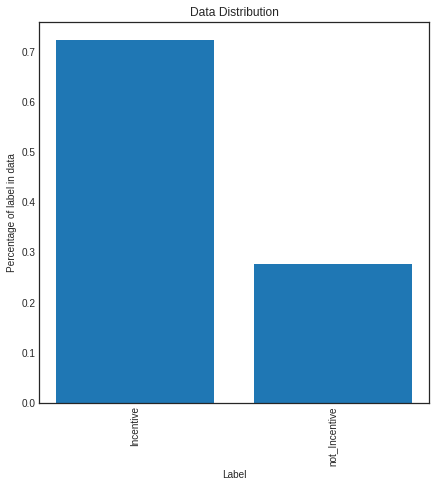

  0%|          | 7/4180 [00:00<01:05, 63.93it/s]

Label counts:
{'Incentive': 0.723404255319149, 'not_Incentive': 0.2765957446808511}
spanish_binary_merged_handpicked

There are 4180 elements in the training dataset 
 There are 141 elements in the test set 

Classifying sentences...


100%|██████████| 141/141 [00:02<00:00, 61.39it/s]


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.95      0.93      0.94       102
not_Incentive       0.83      0.87      0.85        39

     accuracy                           0.91       141
    macro avg       0.89      0.90      0.90       141
 weighted avg       0.92      0.91      0.92       141

Macro/Weighted Avg F1-score: [0.895, 0.916]
\###### [0.895, 0.916] ######

Time taken for fine-tuning: 00:01:59.25


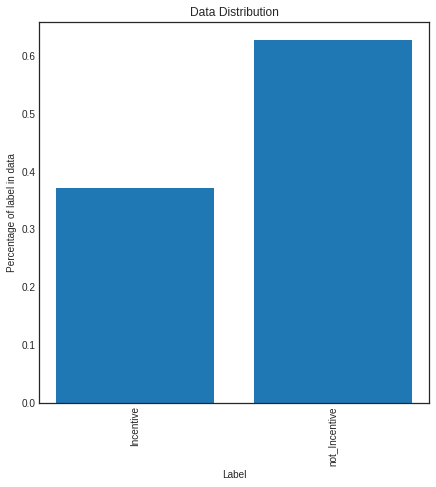

Label counts:
{'Incentive': 0.3723756906077348, 'not_Incentive': 0.6276243093922652}


  0%|          | 6/4180 [00:00<01:11, 58.27it/s]

spanish_binary_merged_assisted

There are 4180 elements in the training dataset 
 There are 905 elements in the test set 

Classifying sentences...


100%|██████████| 905/905 [00:14<00:00, 62.38it/s]


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.93      0.91      0.92       337
not_Incentive       0.94      0.96      0.95       568

     accuracy                           0.94       905
    macro avg       0.94      0.93      0.93       905
 weighted avg       0.94      0.94      0.94       905

Macro/Weighted Avg F1-score: [0.935, 0.939]
\###### [0.935, 0.939] ######

Time taken for fine-tuning: 00:02:15.90


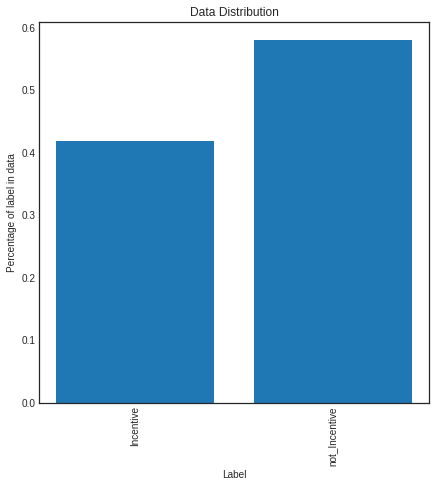

Label counts:
{'Incentive': 0.4196940726577438, 'not_Incentive': 0.5803059273422562}


  0%|          | 7/4180 [00:00<01:05, 63.37it/s]

spanish_binary_merged_merged

There are 4180 elements in the training dataset 
 There are 1046 elements in the test set 

Classifying sentences...


100%|██████████| 1046/1046 [00:16<00:00, 63.69it/s]


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.84      0.84      0.84       439
not_Incentive       0.88      0.89      0.88       607

     accuracy                           0.87      1046
    macro avg       0.86      0.86      0.86      1046
 weighted avg       0.87      0.87      0.87      1046

Macro/Weighted Avg F1-score: [0.863, 0.866]
\###### [0.863, 0.866] ######

Time taken for fine-tuning: 00:02:16.27


_runtime,727
_timestamp,1624986191
_step,21


_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▇▇▇▇███
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▇▇▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██


Fine tuning parameters:
{
    "all_dev_perc": 0.2,
    "model_names": "paraphrase-xlm-r-multilingual-v1",
    "output_path": "/content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent/Modeling/HSSC/Results/",
    "max_num_epochs": 10,
    "group_name": "spanish_multiclass_handpicked"
}

 This is the length of the training set: 217


Evaluating: 100%|██████████| 4/4 [00:00<00:00, 28.19it/s]

Evaluating: 100%|██████████| 4/4 [00:00<00:00, 29.86it/s]

Evaluating: 100%|██████████| 4/4 [00:00<00:00, 29.60it/s]

Evaluating: 100%|██████████| 4/4 [00:00<00:00, 29.82it/s]

Evaluating: 100%|██████████| 4/4 [00:00<00:00, 29.80it/s]

Evaluating: 100%|██████████| 4/4 [00:00<00:00, 31.19it/s]

Evaluating: 100%|██████████| 4/4 [00:00<00:00, 30.55it/s]

Evaluating: 100%|██████████| 4/4 [00:00<00:00, 30.96it/s]

Evaluating: 100%|██████████| 4/4 [00:00<00:00, 29.21it/s]

Evaluating: 100%|██████████| 4/4 [00:00<00:00, 31.21it/s]

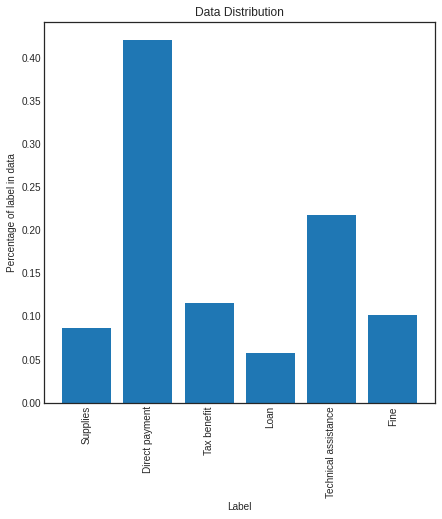

  0%|          | 0/272 [00:00<?, ?it/s]

Label counts:
{'Supplies': 0.08695652173913043, 'Direct payment': 0.42028985507246375, 'Tax benefit': 0.11594202898550725, 'Loan': 0.057971014492753624, 'Technical assistance': 0.21739130434782608, 'Fine': 0.10144927536231885}
spanish_multiclass_handpicked_handpicked

There are 272 elements in the training dataset 
 There are 69 elements in the test set 

Classifying sentences...


100%|██████████| 69/69 [00:01<00:00, 55.14it/s]


Evaluating predictions...
                      precision    recall  f1-score   support

      Direct payment       0.84      0.90      0.87        29
                Fine       1.00      0.86      0.92         7
                Loan       0.67      1.00      0.80         4
            Supplies       1.00      0.67      0.80         6
         Tax benefit       1.00      0.75      0.86         8
Technical assistance       0.81      0.87      0.84        15

            accuracy                           0.86        69
           macro avg       0.89      0.84      0.85        69
        weighted avg       0.87      0.86      0.86        69

Macro/Weighted Avg F1-score: [0.848, 0.856]
\###### [0.848, 0.856] ######

Time taken for fine-tuning: 00:00:09.29


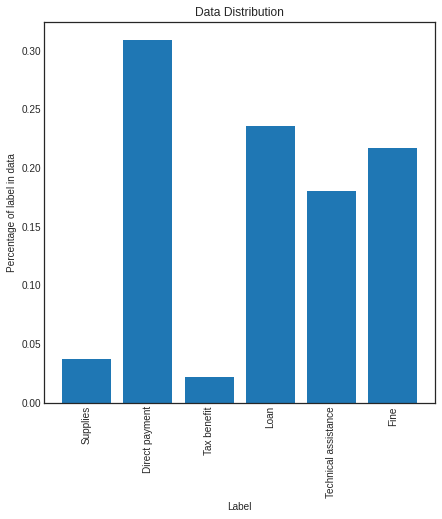

  0%|          | 0/272 [00:00<?, ?it/s]

Label counts:
{'Supplies': 0.03676470588235294, 'Direct payment': 0.3088235294117647, 'Tax benefit': 0.022058823529411766, 'Loan': 0.23529411764705882, 'Technical assistance': 0.1801470588235294, 'Fine': 0.21691176470588236}
spanish_multiclass_handpicked_assisted

There are 272 elements in the training dataset 
 There are 272 elements in the test set 

Classifying sentences...


100%|██████████| 272/272 [00:04<00:00, 54.95it/s]


Evaluating predictions...
                      precision    recall  f1-score   support

      Direct payment       0.61      0.87      0.72        84
                Fine       0.95      0.88      0.91        59
                Loan       0.84      0.33      0.47        64
            Supplies       0.67      0.40      0.50        10
         Tax benefit       0.18      0.50      0.26         6
Technical assistance       0.82      0.82      0.82        49

            accuracy                           0.71       272
           macro avg       0.68      0.63      0.61       272
        weighted avg       0.77      0.71      0.70       272

Macro/Weighted Avg F1-score: [0.613, 0.701]
\###### [0.613, 0.701] ######

Time taken for fine-tuning: 00:00:13.76


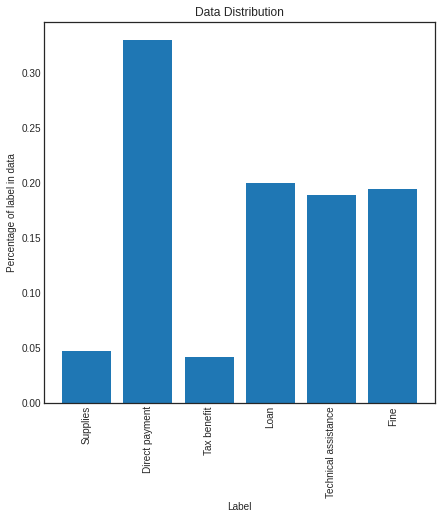

Label counts:
{'Supplies': 0.047058823529411764, 'Direct payment': 0.32941176470588235, 'Tax benefit': 0.041176470588235294, 'Loan': 0.2, 'Technical assistance': 0.18823529411764706, 'Fine': 0.19411764705882353}


  0%|          | 0/272 [00:00<?, ?it/s]

spanish_multiclass_handpicked_merged

There are 272 elements in the training dataset 
 There are 340 elements in the test set 

Classifying sentences...


100%|██████████| 340/340 [00:06<00:00, 55.60it/s]


Evaluating predictions...
                      precision    recall  f1-score   support

      Direct payment       0.65      0.91      0.76       112
                Fine       0.93      0.82      0.87        66
                Loan       0.79      0.34      0.47        68
            Supplies       0.92      0.69      0.79        16
         Tax benefit       0.59      0.93      0.72        14
Technical assistance       0.90      0.86      0.88        64

            accuracy                           0.76       340
           macro avg       0.80      0.76      0.75       340
        weighted avg       0.79      0.76      0.75       340

Macro/Weighted Avg F1-score: [0.748, 0.745]
\###### [0.748, 0.745] ######

Time taken for fine-tuning: 00:00:15.90


_runtime,134
_timestamp,1624986328
_step,21


_runtime,▁▂▂▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
_timestamp,▁▂▂▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██


Fine tuning parameters:
{
    "all_dev_perc": 0.2,
    "model_names": "paraphrase-xlm-r-multilingual-v1",
    "output_path": "/content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent/Modeling/HSSC/Results/",
    "max_num_epochs": 10,
    "group_name": "spanish_multiclass_assisted"
}

 This is the length of the training set: 869


Evaluating:  29%|██▊       | 4/14 [00:00<00:00, 29.11it/s]

Evaluating: 100%|██████████| 14/14 [00:00<00:00, 31.28it/s]


Evaluating:  29%|██▊       | 4/14 [00:00<00:00, 32.73it/s]

Evaluating: 100%|██████████| 14/14 [00:00<00:00, 32.66it/s]


Evaluating:  21%|██▏       | 3/14 [00:00<00:00, 28.23it/s]

Evaluating: 100%|██████████| 14/14 [00:00<00:00, 30.11it/s]


Evaluating:  29%|██▊       | 4/14 [00:00<00:00, 30.92it/s]

Evaluating: 100%|██████████| 14/14 [00:00<00:00, 29.48it/s]


Evaluating:  21%|██▏       | 3/14 [00:00<00:00, 26.60it/s]

Evaluating: 100%|██████████| 14/14 [00:00<00:00, 31.48it/s]


Evaluating:  21%|██▏       | 3/14 [00:00<00:00, 27.81it/s]

Evaluating: 100%|██████████| 14/14 [00:00<00:00, 31.74it/s]


Evaluating:  21%|██▏       | 3/14 [00:00<00:00, 28.17it/s]

Evaluating: 100%|██████████| 14/14 [00:00<00:00, 30.76it/s]


Evaluating:  21%|██▏       | 3/14 [00:00<00:00, 29.39it/s]

Evaluating: 100%|██████████| 14/14 [00:00<00:00, 31.00it/s]


Evaluating:  29%|██▊       | 4/14 [00:00<00:00, 36.17it/s]

Evaluating: 100%|██████████| 14/14 [00:00<00:00, 32.50it/s]


Evaluating:  29%|██▊       | 4/14 [00:00<00:00, 33.48it/s]

Evaluating: 100%|██████████| 14/14 [00:00<00:00, 31.28it/s]


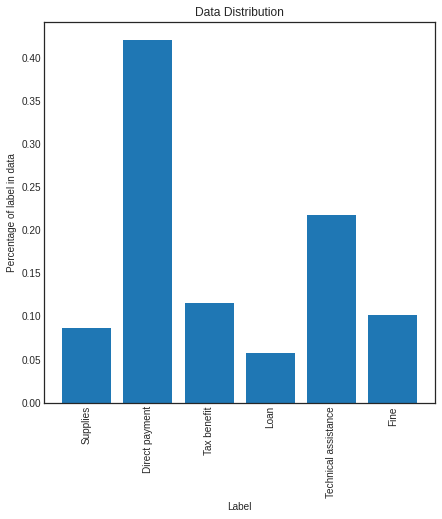

  0%|          | 0/1087 [00:00<?, ?it/s]

Label counts:
{'Supplies': 0.08695652173913043, 'Direct payment': 0.42028985507246375, 'Tax benefit': 0.11594202898550725, 'Loan': 0.057971014492753624, 'Technical assistance': 0.21739130434782608, 'Fine': 0.10144927536231885}
spanish_multiclass_assisted_handpicked

There are 1087 elements in the training dataset 
 There are 69 elements in the test set 

Classifying sentences...


100%|██████████| 69/69 [00:01<00:00, 55.36it/s]


Evaluating predictions...
                      precision    recall  f1-score   support

      Direct payment       0.71      0.83      0.76        29
                Fine       0.75      0.86      0.80         7
                Loan       1.00      1.00      1.00         4
            Supplies       0.25      0.17      0.20         6
         Tax benefit       1.00      0.25      0.40         8
Technical assistance       0.76      0.87      0.81        15

            accuracy                           0.72        69
           macro avg       0.75      0.66      0.66        69
        weighted avg       0.73      0.72      0.70        69

Macro/Weighted Avg F1-score: [0.662, 0.7]
\###### [0.662, 0.7] ######

Time taken for fine-tuning: 00:00:25.88


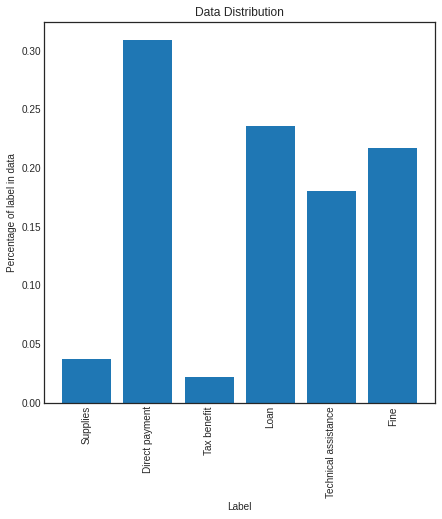

  1%|          | 6/1087 [00:00<00:18, 57.78it/s]

Label counts:
{'Supplies': 0.03676470588235294, 'Direct payment': 0.3088235294117647, 'Tax benefit': 0.022058823529411766, 'Loan': 0.23529411764705882, 'Technical assistance': 0.1801470588235294, 'Fine': 0.21691176470588236}
spanish_multiclass_assisted_assisted

There are 1087 elements in the training dataset 
 There are 272 elements in the test set 

Classifying sentences...


100%|██████████| 272/272 [00:04<00:00, 61.37it/s]


Evaluating predictions...
                      precision    recall  f1-score   support

      Direct payment       0.90      0.90      0.90        84
                Fine       0.97      1.00      0.98        59
                Loan       0.90      0.86      0.88        64
            Supplies       0.88      0.70      0.78        10
         Tax benefit       0.44      0.67      0.53         6
Technical assistance       0.88      0.88      0.88        49

            accuracy                           0.90       272
           macro avg       0.83      0.83      0.83       272
        weighted avg       0.90      0.90      0.90       272

Macro/Weighted Avg F1-score: [0.826, 0.898]
\###### [0.826, 0.898] ######

Time taken for fine-tuning: 00:00:28.20


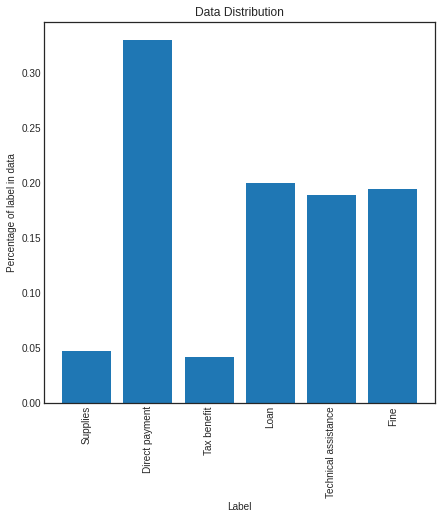

Label counts:
{'Supplies': 0.047058823529411764, 'Direct payment': 0.32941176470588235, 'Tax benefit': 0.041176470588235294, 'Loan': 0.2, 'Technical assistance': 0.18823529411764706, 'Fine': 0.19411764705882353}


  1%|          | 6/1087 [00:00<00:18, 57.50it/s]

spanish_multiclass_assisted_merged

There are 1087 elements in the training dataset 
 There are 340 elements in the test set 

Classifying sentences...


100%|██████████| 340/340 [00:05<00:00, 60.90it/s]


Evaluating predictions...
                      precision    recall  f1-score   support

      Direct payment       0.87      0.95      0.91       112
                Fine       0.98      0.98      0.98        66
                Loan       0.97      0.93      0.95        68
            Supplies       0.92      0.75      0.83        16
         Tax benefit       0.67      0.43      0.52        14
Technical assistance       0.94      0.95      0.95        64

            accuracy                           0.92       340
           macro avg       0.89      0.83      0.86       340
        weighted avg       0.92      0.92      0.92       340

Macro/Weighted Avg F1-score: [0.856, 0.918]
\###### [0.856, 0.918] ######

Time taken for fine-tuning: 00:00:30.03


_runtime,210
_timestamp,1624986542
_step,21


_runtime,▁▂▂▂▃▃▄▄▄▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▂▂▂▃▃▄▄▄▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██


Fine tuning parameters:
{
    "all_dev_perc": 0.2,
    "model_names": "paraphrase-xlm-r-multilingual-v1",
    "output_path": "/content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent/Modeling/HSSC/Results/",
    "max_num_epochs": 10,
    "group_name": "spanish_multiclass_merged"
}

 This is the length of the training set: 1088


Evaluating:  18%|█▊        | 3/17 [00:00<00:00, 25.84it/s]

Evaluating: 100%|██████████| 17/17 [00:00<00:00, 27.42it/s]


Evaluating:  24%|██▎       | 4/17 [00:00<00:00, 30.04it/s]

Evaluating: 100%|██████████| 17/17 [00:00<00:00, 27.60it/s]


Evaluating:  18%|█▊        | 3/17 [00:00<00:00, 27.67it/s]

Evaluating: 100%|██████████| 17/17 [00:00<00:00, 28.92it/s]


Evaluating:  18%|█▊        | 3/17 [00:00<00:00, 25.69it/s]

Evaluating: 100%|██████████| 17/17 [00:00<00:00, 28.45it/s]


Evaluating:  24%|██▎       | 4/17 [00:00<00:00, 31.50it/s]

Evaluating: 100%|██████████| 17/17 [00:00<00:00, 27.99it/s]


Evaluating:  18%|█▊        | 3/17 [00:00<00:00, 27.84it/s]

Evaluating: 100%|██████████| 17/17 [00:00<00:00, 28.76it/s]


Evaluating:  24%|██▎       | 4/17 [00:00<00:00, 34.20it/s]

Evaluating: 100%|██████████| 17/17 [00:00<00:00, 29.19it/s]


Evaluating:  18%|█▊        | 3/17 [00:00<00:00, 27.73it/s]

Evaluating: 100%|██████████| 17/17 [00:00<00:00, 28.84it/s]


Evaluating:  18%|█▊        | 3/17 [00:00<00:00, 29.19it/s]

Evaluating: 100%|██████████| 17/17 [00:00<00:00, 28.19it/s]


Evaluating:  24%|██▎       | 4/17 [00:00<00:00, 32.60it/s]

Evaluating: 100%|██████████| 17/17 [00:00<00:00, 30.09it/s]


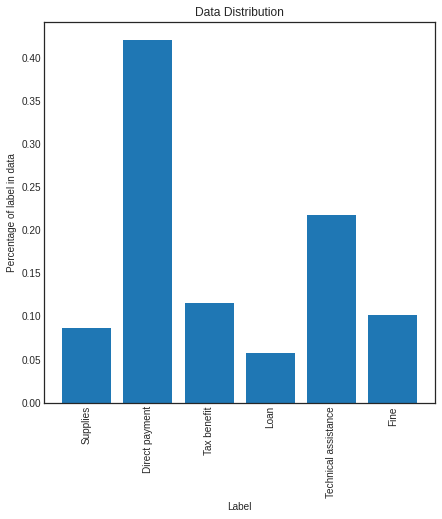

  0%|          | 0/1360 [00:00<?, ?it/s]

Label counts:
{'Supplies': 0.08695652173913043, 'Direct payment': 0.42028985507246375, 'Tax benefit': 0.11594202898550725, 'Loan': 0.057971014492753624, 'Technical assistance': 0.21739130434782608, 'Fine': 0.10144927536231885}
spanish_multiclass_merged_handpicked

There are 1360 elements in the training dataset 
 There are 69 elements in the test set 

Classifying sentences...


100%|██████████| 69/69 [00:01<00:00, 55.38it/s]


Evaluating predictions...
                      precision    recall  f1-score   support

      Direct payment       0.97      0.97      0.97        29
                Fine       0.88      1.00      0.93         7
                Loan       1.00      1.00      1.00         4
            Supplies       1.00      1.00      1.00         6
         Tax benefit       1.00      1.00      1.00         8
Technical assistance       1.00      0.93      0.97        15

            accuracy                           0.97        69
           macro avg       0.97      0.98      0.98        69
        weighted avg       0.97      0.97      0.97        69

Macro/Weighted Avg F1-score: [0.977, 0.971]
\###### [0.977, 0.971] ######

Time taken for fine-tuning: 00:00:31.36


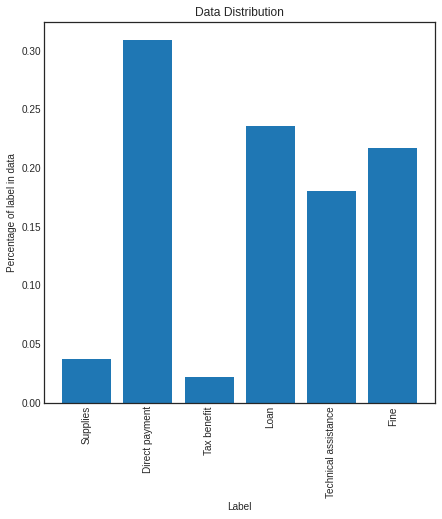

Label counts:
{'Supplies': 0.03676470588235294, 'Direct payment': 0.3088235294117647, 'Tax benefit': 0.022058823529411766, 'Loan': 0.23529411764705882, 'Technical assistance': 0.1801470588235294, 'Fine': 0.21691176470588236}


  0%|          | 0/1360 [00:00<?, ?it/s]

spanish_multiclass_merged_assisted

There are 1360 elements in the training dataset 
 There are 272 elements in the test set 

Classifying sentences...


100%|██████████| 272/272 [00:04<00:00, 63.26it/s]


Evaluating predictions...
                      precision    recall  f1-score   support

      Direct payment       0.95      0.94      0.95        84
                Fine       1.00      1.00      1.00        59
                Loan       0.94      0.94      0.94        64
            Supplies       1.00      0.90      0.95        10
         Tax benefit       0.60      1.00      0.75         6
Technical assistance       0.96      0.92      0.94        49

            accuracy                           0.95       272
           macro avg       0.91      0.95      0.92       272
        weighted avg       0.95      0.95      0.95       272

Macro/Weighted Avg F1-score: [0.92, 0.95]
\###### [0.92, 0.95] ######

Time taken for fine-tuning: 00:00:33.09


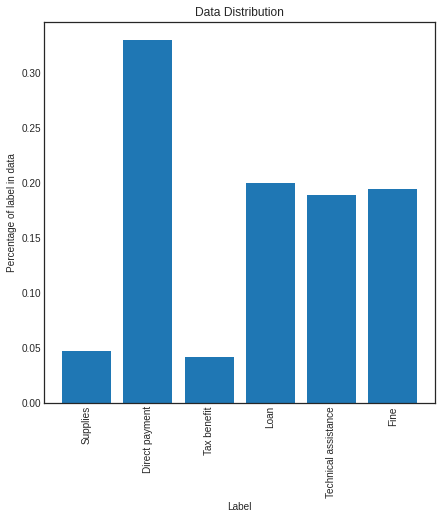

Label counts:
{'Supplies': 0.047058823529411764, 'Direct payment': 0.32941176470588235, 'Tax benefit': 0.041176470588235294, 'Loan': 0.2, 'Technical assistance': 0.18823529411764706, 'Fine': 0.19411764705882353}


  0%|          | 0/1360 [00:00<?, ?it/s]

spanish_multiclass_merged_merged

There are 1360 elements in the training dataset 
 There are 340 elements in the test set 

Classifying sentences...


100%|██████████| 340/340 [00:05<00:00, 61.98it/s]


Evaluating predictions...
                      precision    recall  f1-score   support

      Direct payment       0.88      0.88      0.88       112
                Fine       0.94      0.98      0.96        66
                Loan       0.91      0.88      0.90        68
            Supplies       0.93      0.88      0.90        16
         Tax benefit       0.59      0.71      0.65        14
Technical assistance       0.94      0.91      0.92        64

            accuracy                           0.90       340
           macro avg       0.87      0.87      0.87       340
        weighted avg       0.90      0.90      0.90       340

Macro/Weighted Avg F1-score: [0.868, 0.898]
\###### [0.868, 0.898] ######

Time taken for fine-tuning: 00:00:34.85


_runtime,234
_timestamp,1624986779
_step,21


_runtime,▁▂▂▂▃▃▄▄▄▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▂▂▂▃▃▄▄▄▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██


Fine tuning parameters:
{
    "all_dev_perc": 0.2,
    "model_names": "paraphrase-xlm-r-multilingual-v1",
    "output_path": "/content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent/Modeling/HSSC/Results/",
    "max_num_epochs": 10,
    "group_name": "english_binary_handpicked"
}

 This is the length of the training set: 883


Evaluating:  29%|██▊       | 4/14 [00:00<00:00, 32.10it/s]

Evaluating: 100%|██████████| 14/14 [00:00<00:00, 32.89it/s]


Evaluating:  29%|██▊       | 4/14 [00:00<00:00, 34.76it/s]

Evaluating: 100%|██████████| 14/14 [00:00<00:00, 32.90it/s]


Evaluating:  29%|██▊       | 4/14 [00:00<00:00, 32.92it/s]

Evaluating: 100%|██████████| 14/14 [00:00<00:00, 31.07it/s]


Evaluating:  36%|███▌      | 5/14 [00:00<00:00, 39.80it/s]

Evaluating: 100%|██████████| 14/14 [00:00<00:00, 33.82it/s]


Evaluating:  29%|██▊       | 4/14 [00:00<00:00, 36.53it/s]

Evaluating: 100%|██████████| 14/14 [00:00<00:00, 34.59it/s]


Evaluating:  29%|██▊       | 4/14 [00:00<00:00, 34.51it/s]

Evaluating: 100%|██████████| 14/14 [00:00<00:00, 31.95it/s]


Evaluating:  29%|██▊       | 4/14 [00:00<00:00, 32.68it/s]

Evaluating: 100%|██████████| 14/14 [00:00<00:00, 32.49it/s]


Evaluating:  29%|██▊       | 4/14 [00:00<00:00, 35.20it/s]

Evaluating: 100%|██████████| 14/14 [00:00<00:00, 34.75it/s]


Evaluating:  21%|██▏       | 3/14 [00:00<00:00, 27.64it/s]

Evaluating: 100%|██████████| 14/14 [00:00<00:00, 34.55it/s]


Evaluating:  21%|██▏       | 3/14 [00:00<00:00, 28.91it/s]

Evaluating: 100%|██████████| 14/14 [00:00<00:00, 34.21it/s]


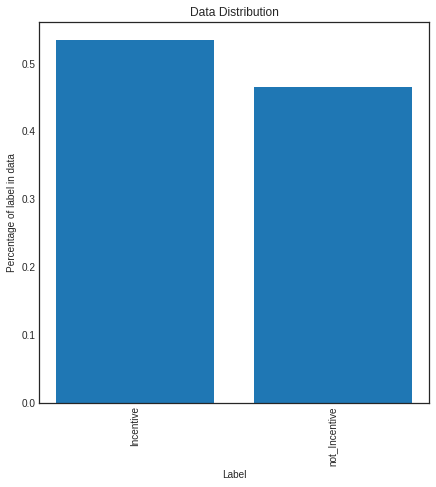

  1%|          | 6/1104 [00:00<00:19, 57.10it/s]

Label counts:
{'Incentive': 0.5342960288808665, 'not_Incentive': 0.4657039711191336}
english_binary_handpicked_handpicked

There are 1104 elements in the training dataset 
 There are 277 elements in the test set 

Classifying sentences...


100%|██████████| 277/277 [00:04<00:00, 56.33it/s]


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.84      0.91      0.88       148
not_Incentive       0.89      0.81      0.85       129

     accuracy                           0.86       277
    macro avg       0.87      0.86      0.86       277
 weighted avg       0.86      0.86      0.86       277

Macro/Weighted Avg F1-score: [0.861, 0.862]
\###### [0.861, 0.862] ######

Time taken for fine-tuning: 00:00:30.96


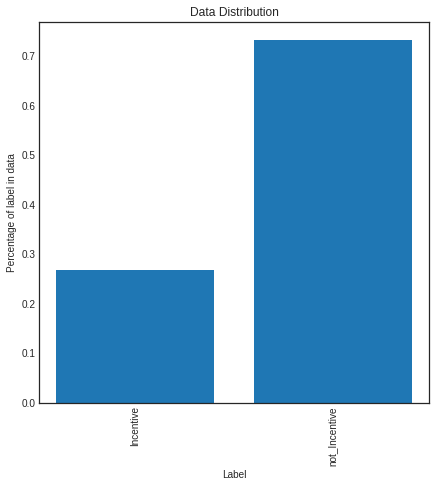

Label counts:
{'Incentive': 0.26788685524126454, 'not_Incentive': 0.7321131447587355}


  1%|          | 7/1104 [00:00<00:18, 60.43it/s]

english_binary_handpicked_assisted

There are 1104 elements in the training dataset 
 There are 601 elements in the test set 

Classifying sentences...


100%|██████████| 601/601 [00:09<00:00, 62.76it/s]


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.53      0.58      0.55       161
not_Incentive       0.84      0.81      0.82       440

     accuracy                           0.75       601
    macro avg       0.68      0.70      0.69       601
 weighted avg       0.76      0.75      0.75       601

Macro/Weighted Avg F1-score: [0.688, 0.751]
\###### [0.688, 0.751] ######

Time taken for fine-tuning: 00:00:37.06


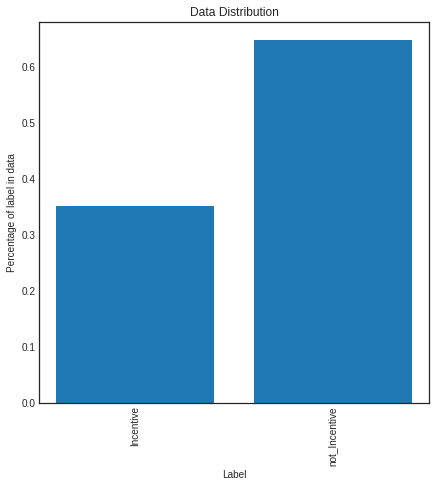

Label counts:
{'Incentive': 0.3523375142531357, 'not_Incentive': 0.6476624857468644}


  1%|          | 6/1104 [00:00<00:18, 59.75it/s]

english_binary_handpicked_merged

There are 1104 elements in the training dataset 
 There are 877 elements in the test set 

Classifying sentences...


100%|██████████| 877/877 [00:13<00:00, 64.12it/s]


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.77      0.75      0.76       309
not_Incentive       0.87      0.88      0.87       568

     accuracy                           0.83       877
    macro avg       0.82      0.81      0.82       877
 weighted avg       0.83      0.83      0.83       877

Macro/Weighted Avg F1-score: [0.816, 0.832]
\###### [0.816, 0.832] ######

Time taken for fine-tuning: 00:00:43.62


_runtime,218
_timestamp,1624987001
_step,21


_runtime,▁▁▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆███
_timestamp,▁▁▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆███
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██


Fine tuning parameters:
{
    "all_dev_perc": 0.2,
    "model_names": "paraphrase-xlm-r-multilingual-v1",
    "output_path": "/content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent/Modeling/HSSC/Results/",
    "max_num_epochs": 10,
    "group_name": "english_binary_assisted"
}

 This is the length of the training set: 1920


Evaluating:  13%|█▎        | 4/30 [00:00<00:00, 34.22it/s]

Evaluating: 100%|██████████| 30/30 [00:00<00:00, 31.87it/s]


Evaluating:  13%|█▎        | 4/30 [00:00<00:00, 39.15it/s]

Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.75it/s]


Evaluating:  13%|█▎        | 4/30 [00:00<00:00, 31.09it/s]

Evaluating: 100%|██████████| 30/30 [00:00<00:00, 32.34it/s]


Evaluating:  13%|█▎        | 4/30 [00:00<00:00, 34.78it/s]

Evaluating: 100%|██████████| 30/30 [00:00<00:00, 31.52it/s]


Evaluating:  10%|█         | 3/30 [00:00<00:00, 29.17it/s]

Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.57it/s]


Evaluating:  10%|█         | 3/30 [00:00<00:00, 29.42it/s]

Evaluating: 100%|██████████| 30/30 [00:00<00:00, 31.03it/s]


Evaluating:  10%|█         | 3/30 [00:00<00:00, 27.60it/s]

Evaluating: 100%|██████████| 30/30 [00:00<00:00, 31.37it/s]


Evaluating:  10%|█         | 3/30 [00:00<00:01, 25.30it/s]

Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.69it/s]


Evaluating:  10%|█         | 3/30 [00:00<00:00, 29.30it/s]

Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.73it/s]


Evaluating:  10%|█         | 3/30 [00:00<00:00, 29.95it/s]

Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.79it/s]


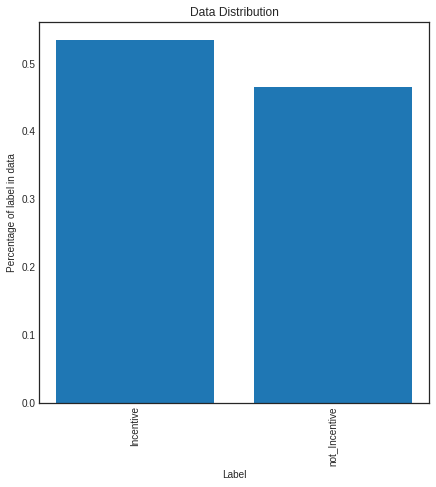

  0%|          | 6/2400 [00:00<00:43, 55.60it/s]

Label counts:
{'Incentive': 0.5342960288808665, 'not_Incentive': 0.4657039711191336}
english_binary_assisted_handpicked

There are 2400 elements in the training dataset 
 There are 277 elements in the test set 

Classifying sentences...


100%|██████████| 277/277 [00:04<00:00, 63.15it/s]


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.71      0.48      0.57       148
not_Incentive       0.56      0.78      0.65       129

     accuracy                           0.62       277
    macro avg       0.64      0.63      0.61       277
 weighted avg       0.64      0.62      0.61       277

Macro/Weighted Avg F1-score: [0.613, 0.61]
\###### [0.613, 0.61] ######

Time taken for fine-tuning: 00:01:00.84


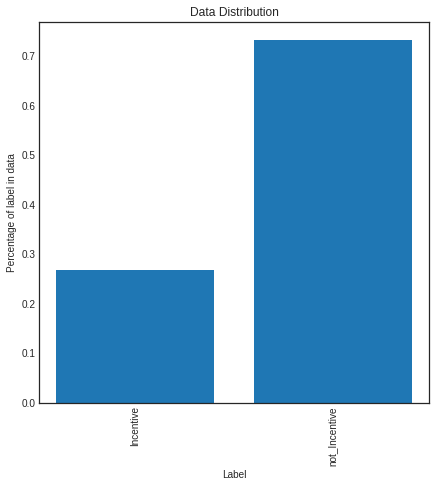

Label counts:
{'Incentive': 0.26788685524126454, 'not_Incentive': 0.7321131447587355}


  0%|          | 7/2400 [00:00<00:39, 61.32it/s]

english_binary_assisted_assisted

There are 2400 elements in the training dataset 
 There are 601 elements in the test set 

Classifying sentences...


100%|██████████| 601/601 [00:09<00:00, 61.63it/s]


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.84      0.83      0.83       161
not_Incentive       0.94      0.94      0.94       440

     accuracy                           0.91       601
    macro avg       0.89      0.88      0.89       601
 weighted avg       0.91      0.91      0.91       601

Macro/Weighted Avg F1-score: [0.885, 0.91]
\###### [0.885, 0.91] ######

Time taken for fine-tuning: 00:01:07.02


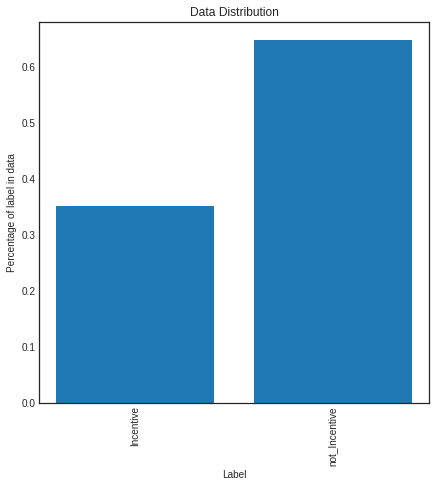

Label counts:
{'Incentive': 0.3523375142531357, 'not_Incentive': 0.6476624857468644}


  0%|          | 6/2400 [00:00<00:40, 59.06it/s]

english_binary_assisted_merged

There are 2400 elements in the training dataset 
 There are 877 elements in the test set 

Classifying sentences...


100%|██████████| 877/877 [00:13<00:00, 62.88it/s]


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.88      0.67      0.76       309
not_Incentive       0.84      0.95      0.89       568

     accuracy                           0.85       877
    macro avg       0.86      0.81      0.83       877
 weighted avg       0.86      0.85      0.85       877

Macro/Weighted Avg F1-score: [0.827, 0.846]
\###### [0.827, 0.846] ######

Time taken for fine-tuning: 00:01:12.99


_runtime,394
_timestamp,1624987398
_step,21


_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▇▇▇▇███
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▇▇▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██


Fine tuning parameters:
{
    "all_dev_perc": 0.2,
    "model_names": "paraphrase-xlm-r-multilingual-v1",
    "output_path": "/content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent/Modeling/HSSC/Results/",
    "max_num_epochs": 10,
    "group_name": "english_binary_merged"
}

 This is the length of the training set: 2804


Evaluating:   9%|▉         | 4/44 [00:00<00:01, 37.80it/s]

Evaluating: 100%|██████████| 44/44 [00:01<00:00, 29.69it/s]


Evaluating:   9%|▉         | 4/44 [00:00<00:01, 31.37it/s]

Evaluating: 100%|██████████| 44/44 [00:01<00:00, 29.82it/s]


Evaluating:   9%|▉         | 4/44 [00:00<00:01, 33.63it/s]

Evaluating: 100%|██████████| 44/44 [00:01<00:00, 28.74it/s]


Evaluating:   7%|▋         | 3/44 [00:00<00:01, 25.68it/s]

Evaluating: 100%|██████████| 44/44 [00:01<00:00, 30.27it/s]


Evaluating:   7%|▋         | 3/44 [00:00<00:01, 29.64it/s]

Evaluating: 100%|██████████| 44/44 [00:01<00:00, 28.33it/s]


Evaluating:   7%|▋         | 3/44 [00:00<00:01, 28.54it/s]

Evaluating: 100%|██████████| 44/44 [00:01<00:00, 30.45it/s]


Evaluating:   7%|▋         | 3/44 [00:00<00:01, 28.25it/s]

Evaluating: 100%|██████████| 44/44 [00:01<00:00, 30.09it/s]


Evaluating:   7%|▋         | 3/44 [00:00<00:01, 29.71it/s]

Evaluating: 100%|██████████| 44/44 [00:01<00:00, 29.77it/s]


Evaluating:   7%|▋         | 3/44 [00:00<00:01, 28.60it/s]

Evaluating: 100%|██████████| 44/44 [00:01<00:00, 30.28it/s]


Evaluating:   9%|▉         | 4/44 [00:00<00:01, 31.18it/s]

Evaluating: 100%|██████████| 44/44 [00:01<00:00, 30.22it/s]


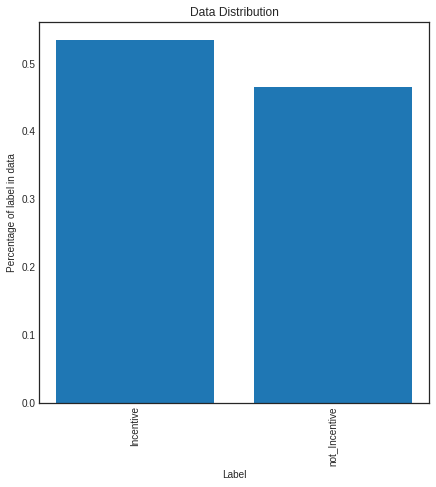

  0%|          | 6/3505 [00:00<01:01, 56.93it/s]

Label counts:
{'Incentive': 0.5342960288808665, 'not_Incentive': 0.4657039711191336}
english_binary_merged_handpicked

There are 3505 elements in the training dataset 
 There are 277 elements in the test set 

Classifying sentences...


100%|██████████| 277/277 [00:04<00:00, 62.63it/s]


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.95      0.97      0.96       148
not_Incentive       0.97      0.95      0.96       129

     accuracy                           0.96       277
    macro avg       0.96      0.96      0.96       277
 weighted avg       0.96      0.96      0.96       277

Macro/Weighted Avg F1-score: [0.96, 0.96]
\###### [0.96, 0.96] ######

Time taken for fine-tuning: 00:01:33.22


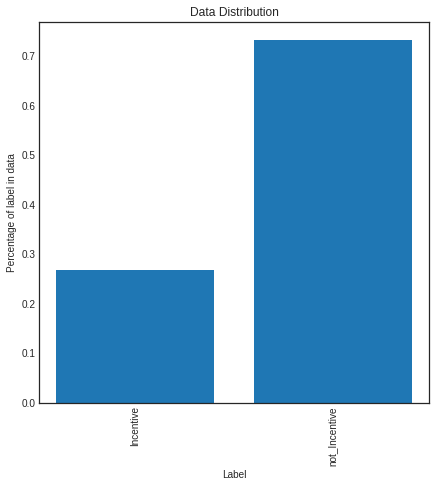

Label counts:
{'Incentive': 0.26788685524126454, 'not_Incentive': 0.7321131447587355}


  0%|          | 7/3505 [00:00<00:53, 65.29it/s]

english_binary_merged_assisted

There are 3505 elements in the training dataset 
 There are 601 elements in the test set 

Classifying sentences...


100%|██████████| 601/601 [00:09<00:00, 62.05it/s]


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.95      0.93      0.94       161
not_Incentive       0.97      0.98      0.98       440

     accuracy                           0.97       601
    macro avg       0.96      0.95      0.96       601
 weighted avg       0.97      0.97      0.97       601

Macro/Weighted Avg F1-score: [0.957, 0.967]
\###### [0.957, 0.967] ######

Time taken for fine-tuning: 00:01:38.18


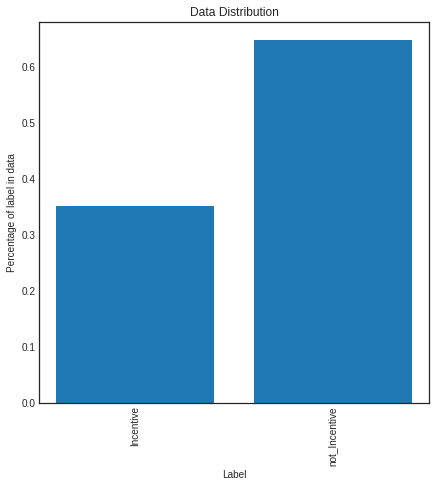

Label counts:
{'Incentive': 0.3523375142531357, 'not_Incentive': 0.6476624857468644}


  0%|          | 7/3505 [00:00<00:57, 61.11it/s]

english_binary_merged_merged

There are 3505 elements in the training dataset 
 There are 877 elements in the test set 

Classifying sentences...


100%|██████████| 877/877 [00:13<00:00, 64.14it/s]


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.87      0.85      0.86       309
not_Incentive       0.92      0.93      0.92       568

     accuracy                           0.90       877
    macro avg       0.89      0.89      0.89       877
 weighted avg       0.90      0.90      0.90       877

Macro/Weighted Avg F1-score: [0.892, 0.902]
\###### [0.892, 0.902] ######

Time taken for fine-tuning: 00:01:43.02


_runtime,568
_timestamp,1624987970
_step,21


_runtime,▁▁▂▂▃▃▃▃▄▄▄▅▅▅▅▇▇▇▇███
_timestamp,▁▁▂▂▃▃▃▃▄▄▄▅▅▅▅▇▇▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██


Fine tuning parameters:
{
    "all_dev_perc": 0.2,
    "model_names": "paraphrase-xlm-r-multilingual-v1",
    "output_path": "/content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent/Modeling/HSSC/Results/",
    "max_num_epochs": 10,
    "group_name": "english_multiclass_handpicked"
}

 This is the length of the training set: 462


Evaluating:  50%|█████     | 4/8 [00:00<00:00, 38.13it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 40.30it/s]


Evaluating:  50%|█████     | 4/8 [00:00<00:00, 34.97it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 39.84it/s]


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 41.90it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 41.95it/s]

Evaluating:  50%|█████     | 4/8 [00:00<00:00, 35.10it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 38.87it/s]


Evaluating:  50%|█████     | 4/8 [00:00<00:00, 38.62it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 38.95it/s]


Evaluating:  50%|█████     | 4/8 [00:00<00:00, 36.61it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 39.92it/s]


Evaluating:  50%|█████     | 4/8 [00:00<00:00, 34.75it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 39.37it/s]


Evaluating:  50%|█████     | 4/8 [00:00<00:00, 34.69it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 38.64it/s]


Evaluating:  62%|██████▎   | 5/8 [00:00<00:00, 43.21it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 39.96it/s]


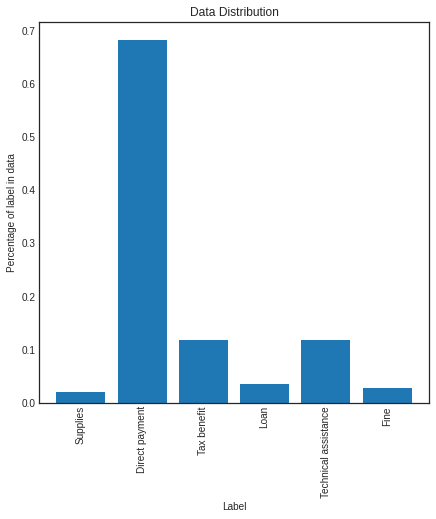

  1%|          | 6/578 [00:00<00:09, 58.64it/s]

Label counts:
{'Supplies': 0.020689655172413793, 'Direct payment': 0.6827586206896552, 'Tax benefit': 0.11724137931034483, 'Loan': 0.034482758620689655, 'Technical assistance': 0.11724137931034483, 'Fine': 0.027586206896551724}
english_multiclass_handpicked_handpicked

There are 578 elements in the training dataset 
 There are 145 elements in the test set 

Classifying sentences...


100%|██████████| 145/145 [00:02<00:00, 55.00it/s]


Evaluating predictions...
                      precision    recall  f1-score   support

      Direct payment       0.94      0.97      0.96        99
                Fine       1.00      0.75      0.86         4
                Loan       0.80      0.80      0.80         5
            Supplies       1.00      0.33      0.50         3
         Tax benefit       0.89      0.94      0.91        17
Technical assistance       0.81      0.76      0.79        17

            accuracy                           0.92       145
           macro avg       0.91      0.76      0.80       145
        weighted avg       0.92      0.92      0.91       145

Macro/Weighted Avg F1-score: [0.802, 0.913]
\###### [0.802, 0.913] ######

Time taken for fine-tuning: 00:00:17.64


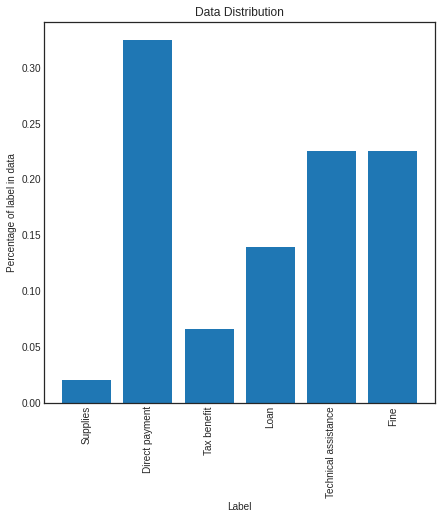

  0%|          | 0/578 [00:00<?, ?it/s]

Label counts:
{'Supplies': 0.019867549668874173, 'Direct payment': 0.32450331125827814, 'Tax benefit': 0.06622516556291391, 'Loan': 0.1390728476821192, 'Technical assistance': 0.2251655629139073, 'Fine': 0.2251655629139073}
english_multiclass_handpicked_assisted

There are 578 elements in the training dataset 
 There are 151 elements in the test set 

Classifying sentences...


100%|██████████| 151/151 [00:02<00:00, 54.67it/s]


Evaluating predictions...
                      precision    recall  f1-score   support

      Direct payment       0.74      1.00      0.85        49
                Fine       1.00      1.00      1.00        34
                Loan       1.00      0.71      0.83        21
            Supplies       1.00      0.33      0.50         3
         Tax benefit       1.00      0.70      0.82        10
Technical assistance       1.00      0.82      0.90        34

            accuracy                           0.89       151
           macro avg       0.96      0.76      0.82       151
        weighted avg       0.92      0.89      0.89       151

Macro/Weighted Avg F1-score: [0.819, 0.885]
\###### [0.819, 0.885] ######

Time taken for fine-tuning: 00:00:17.51


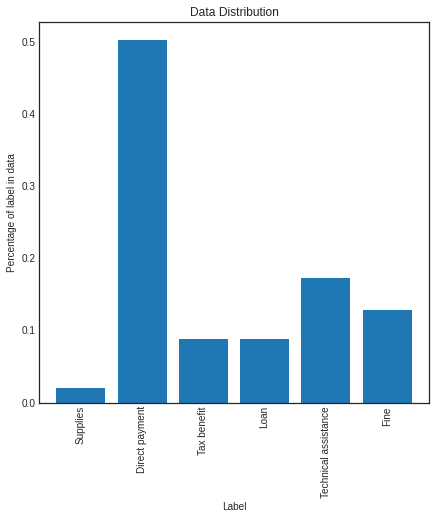

Label counts:
{'Supplies': 0.020338983050847456, 'Direct payment': 0.5016949152542373, 'Tax benefit': 0.08813559322033898, 'Loan': 0.08813559322033898, 'Technical assistance': 0.17288135593220338, 'Fine': 0.1288135593220339}


  0%|          | 0/578 [00:00<?, ?it/s]

english_multiclass_handpicked_merged

There are 578 elements in the training dataset 
 There are 295 elements in the test set 

Classifying sentences...


100%|██████████| 295/295 [00:04<00:00, 62.10it/s]


Evaluating predictions...
                      precision    recall  f1-score   support

      Direct payment       0.89      1.00      0.94       148
                Fine       1.00      1.00      1.00        38
                Loan       1.00      0.88      0.94        26
            Supplies       1.00      0.33      0.50         6
         Tax benefit       1.00      0.88      0.94        26
Technical assistance       0.98      0.80      0.88        51

            accuracy                           0.93       295
           macro avg       0.98      0.82      0.87       295
        weighted avg       0.94      0.93      0.93       295

Macro/Weighted Avg F1-score: [0.866, 0.928]
\###### [0.866, 0.928] ######

Time taken for fine-tuning: 00:00:18.98


_runtime,144
_timestamp,1624988118
_step,21


_runtime,▁▂▂▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▂▂▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██


Fine tuning parameters:
{
    "all_dev_perc": 0.2,
    "model_names": "paraphrase-xlm-r-multilingual-v1",
    "output_path": "/content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent/Modeling/HSSC/Results/",
    "max_num_epochs": 10,
    "group_name": "english_multiclass_assisted"
}

 This is the length of the training set: 480


Evaluating:  38%|███▊      | 3/8 [00:00<00:00, 25.32it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 27.93it/s]


Evaluating:  38%|███▊      | 3/8 [00:00<00:00, 25.70it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 27.55it/s]


Evaluating:  38%|███▊      | 3/8 [00:00<00:00, 24.75it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 27.28it/s]


Evaluating:  38%|███▊      | 3/8 [00:00<00:00, 24.70it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 26.26it/s]


Evaluating:  38%|███▊      | 3/8 [00:00<00:00, 24.48it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 26.55it/s]


Evaluating:  38%|███▊      | 3/8 [00:00<00:00, 23.65it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 25.95it/s]


Evaluating:  38%|███▊      | 3/8 [00:00<00:00, 24.25it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 25.30it/s]


Evaluating:  38%|███▊      | 3/8 [00:00<00:00, 24.98it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 25.95it/s]


Evaluating:  38%|███▊      | 3/8 [00:00<00:00, 24.81it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 26.75it/s]


Evaluating:  38%|███▊      | 3/8 [00:00<00:00, 24.77it/s]

Evaluating: 100%|██████████| 8/8 [00:00<00:00, 27.08it/s]


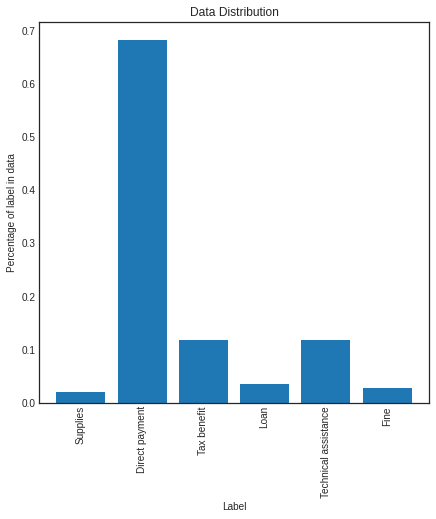

  1%|          | 5/601 [00:00<00:12, 48.41it/s]

Label counts:
{'Supplies': 0.020689655172413793, 'Direct payment': 0.6827586206896552, 'Tax benefit': 0.11724137931034483, 'Loan': 0.034482758620689655, 'Technical assistance': 0.11724137931034483, 'Fine': 0.027586206896551724}
english_multiclass_assisted_handpicked

There are 601 elements in the training dataset 
 There are 145 elements in the test set 

Classifying sentences...


100%|██████████| 145/145 [00:02<00:00, 53.71it/s]


Evaluating predictions...
                      precision    recall  f1-score   support

      Direct payment       0.99      0.71      0.82        99
                Fine       1.00      0.25      0.40         4
                Loan       0.56      1.00      0.71         5
            Supplies       0.15      1.00      0.26         3
         Tax benefit       0.67      0.82      0.74        17
Technical assistance       0.57      0.76      0.65        17

            accuracy                           0.73       145
           macro avg       0.65      0.76      0.60       145
        weighted avg       0.87      0.73      0.77       145

Macro/Weighted Avg F1-score: [0.598, 0.766]
\###### [0.598, 0.766] ######

Time taken for fine-tuning: 00:00:17.29


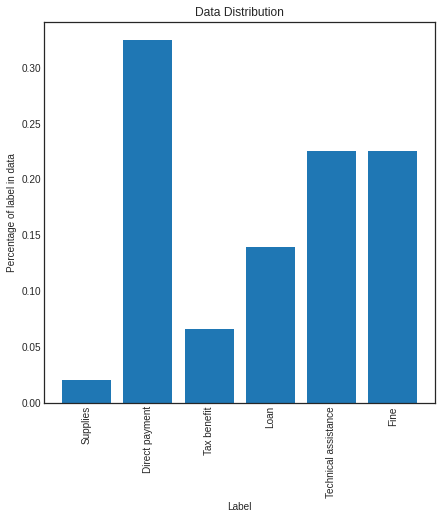

  1%|          | 6/601 [00:00<00:10, 55.99it/s]

Label counts:
{'Supplies': 0.019867549668874173, 'Direct payment': 0.32450331125827814, 'Tax benefit': 0.06622516556291391, 'Loan': 0.1390728476821192, 'Technical assistance': 0.2251655629139073, 'Fine': 0.2251655629139073}
english_multiclass_assisted_assisted

There are 601 elements in the training dataset 
 There are 151 elements in the test set 

Classifying sentences...


100%|██████████| 151/151 [00:02<00:00, 62.60it/s]


Evaluating predictions...
                      precision    recall  f1-score   support

      Direct payment       0.98      0.96      0.97        49
                Fine       1.00      1.00      1.00        34
                Loan       0.95      1.00      0.98        21
            Supplies       1.00      0.67      0.80         3
         Tax benefit       1.00      1.00      1.00        10
Technical assistance       0.97      1.00      0.99        34

            accuracy                           0.98       151
           macro avg       0.98      0.94      0.96       151
        weighted avg       0.98      0.98      0.98       151

Macro/Weighted Avg F1-score: [0.955, 0.979]
\###### [0.955, 0.979] ######

Time taken for fine-tuning: 00:00:17.12


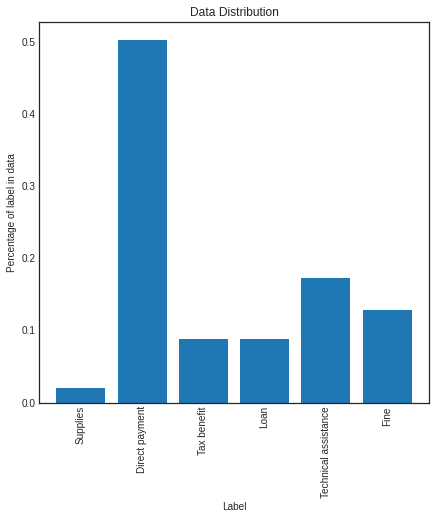

Label counts:
{'Supplies': 0.020338983050847456, 'Direct payment': 0.5016949152542373, 'Tax benefit': 0.08813559322033898, 'Loan': 0.08813559322033898, 'Technical assistance': 0.17288135593220338, 'Fine': 0.1288135593220339}


  0%|          | 0/601 [00:00<?, ?it/s]

english_multiclass_assisted_merged

There are 601 elements in the training dataset 
 There are 295 elements in the test set 

Classifying sentences...


100%|██████████| 295/295 [00:04<00:00, 60.20it/s]


Evaluating predictions...
                      precision    recall  f1-score   support

      Direct payment       0.99      0.80      0.88       148
                Fine       1.00      0.97      0.99        38
                Loan       0.87      1.00      0.93        26
            Supplies       0.24      1.00      0.39         6
         Tax benefit       0.83      0.96      0.89        26
Technical assistance       0.91      0.96      0.93        51

            accuracy                           0.88       295
           macro avg       0.81      0.95      0.84       295
        weighted avg       0.94      0.88      0.90       295

Macro/Weighted Avg F1-score: [0.835, 0.9]
\###### [0.835, 0.9] ######

Time taken for fine-tuning: 00:00:19.29


_runtime,155
_timestamp,1624988277
_step,21


_runtime,▁▂▂▂▃▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▂▂▂▃▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██


Fine tuning parameters:
{
    "all_dev_perc": 0.2,
    "model_names": "paraphrase-xlm-r-multilingual-v1",
    "output_path": "/content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent/Modeling/HSSC/Results/",
    "max_num_epochs": 10,
    "group_name": "english_multiclass_merged"
}

 This is the length of the training set: 944


Evaluating:  20%|██        | 3/15 [00:00<00:00, 25.43it/s]

Evaluating: 100%|██████████| 15/15 [00:00<00:00, 29.45it/s]


Evaluating:  20%|██        | 3/15 [00:00<00:00, 29.82it/s]

Evaluating: 100%|██████████| 15/15 [00:00<00:00, 28.54it/s]


Evaluating:  20%|██        | 3/15 [00:00<00:00, 25.20it/s]

Evaluating: 100%|██████████| 15/15 [00:00<00:00, 27.93it/s]


Evaluating:  20%|██        | 3/15 [00:00<00:00, 28.79it/s]

Evaluating: 100%|██████████| 15/15 [00:00<00:00, 29.53it/s]


Evaluating:  20%|██        | 3/15 [00:00<00:00, 29.67it/s]

Evaluating: 100%|██████████| 15/15 [00:00<00:00, 28.38it/s]


Evaluating:  20%|██        | 3/15 [00:00<00:00, 27.05it/s]

Evaluating: 100%|██████████| 15/15 [00:00<00:00, 29.57it/s]


Evaluating:  20%|██        | 3/15 [00:00<00:00, 28.42it/s]

Evaluating: 100%|██████████| 15/15 [00:00<00:00, 28.39it/s]


Evaluating:  27%|██▋       | 4/15 [00:00<00:00, 29.03it/s]

Evaluating: 100%|██████████| 15/15 [00:00<00:00, 28.80it/s]


Evaluating:  27%|██▋       | 4/15 [00:00<00:00, 30.45it/s]

Evaluating: 100%|██████████| 15/15 [00:00<00:00, 29.78it/s]


Evaluating:  20%|██        | 3/15 [00:00<00:00, 26.38it/s]

Evaluating: 100%|██████████| 15/15 [00:00<00:00, 29.14it/s]


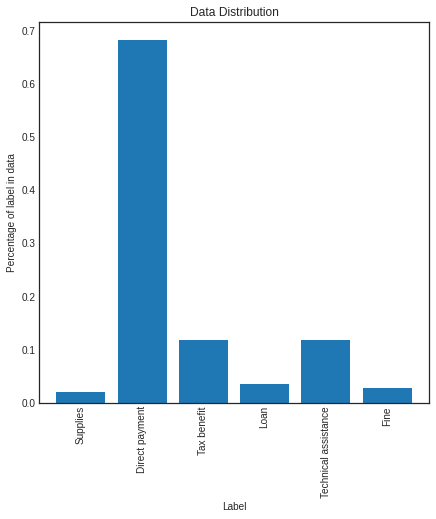

  1%|          | 6/1180 [00:00<00:21, 55.02it/s]

Label counts:
{'Supplies': 0.020689655172413793, 'Direct payment': 0.6827586206896552, 'Tax benefit': 0.11724137931034483, 'Loan': 0.034482758620689655, 'Technical assistance': 0.11724137931034483, 'Fine': 0.027586206896551724}
english_multiclass_merged_handpicked

There are 1180 elements in the training dataset 
 There are 145 elements in the test set 

Classifying sentences...


100%|██████████| 145/145 [00:02<00:00, 52.98it/s]


Evaluating predictions...
                      precision    recall  f1-score   support

      Direct payment       0.99      0.99      0.99        99
                Fine       1.00      1.00      1.00         4
                Loan       1.00      1.00      1.00         5
            Supplies       1.00      1.00      1.00         3
         Tax benefit       1.00      1.00      1.00        17
Technical assistance       0.94      0.94      0.94        17

            accuracy                           0.99       145
           macro avg       0.99      0.99      0.99       145
        weighted avg       0.99      0.99      0.99       145

Macro/Weighted Avg F1-score: [0.989, 0.986]
\###### [0.989, 0.986] ######

Time taken for fine-tuning: 00:00:29.82


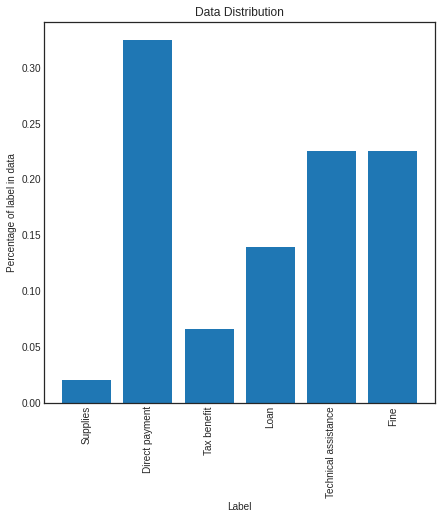

Label counts:
{'Supplies': 0.019867549668874173, 'Direct payment': 0.32450331125827814, 'Tax benefit': 0.06622516556291391, 'Loan': 0.1390728476821192, 'Technical assistance': 0.2251655629139073, 'Fine': 0.2251655629139073}


  0%|          | 0/1180 [00:00<?, ?it/s]

english_multiclass_merged_assisted

There are 1180 elements in the training dataset 
 There are 151 elements in the test set 

Classifying sentences...


100%|██████████| 151/151 [00:02<00:00, 58.95it/s]


Evaluating predictions...
                      precision    recall  f1-score   support

      Direct payment       0.98      0.98      0.98        49
                Fine       1.00      1.00      1.00        34
                Loan       0.91      1.00      0.95        21
            Supplies       1.00      0.67      0.80         3
         Tax benefit       1.00      1.00      1.00        10
Technical assistance       1.00      0.97      0.99        34

            accuracy                           0.98       151
           macro avg       0.98      0.94      0.95       151
        weighted avg       0.98      0.98      0.98       151

Macro/Weighted Avg F1-score: [0.953, 0.98]
\###### [0.953, 0.98] ######

Time taken for fine-tuning: 00:00:27.34


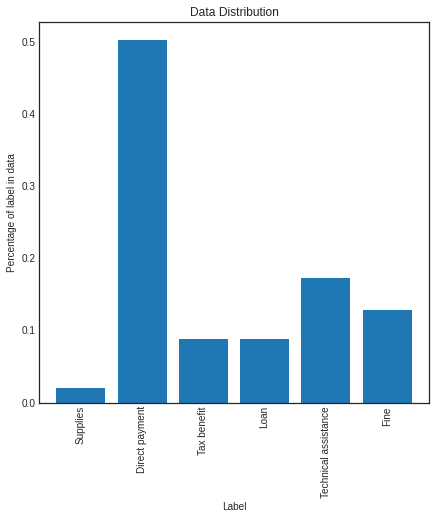

Label counts:
{'Supplies': 0.020338983050847456, 'Direct payment': 0.5016949152542373, 'Tax benefit': 0.08813559322033898, 'Loan': 0.08813559322033898, 'Technical assistance': 0.17288135593220338, 'Fine': 0.1288135593220339}


  0%|          | 0/1180 [00:00<?, ?it/s]

english_multiclass_merged_merged

There are 1180 elements in the training dataset 
 There are 295 elements in the test set 

Classifying sentences...


100%|██████████| 295/295 [00:04<00:00, 60.85it/s]


Evaluating predictions...
                      precision    recall  f1-score   support

      Direct payment       0.95      0.98      0.97       148
                Fine       0.97      1.00      0.99        38
                Loan       0.93      1.00      0.96        26
            Supplies       1.00      0.33      0.50         6
         Tax benefit       1.00      0.92      0.96        26
Technical assistance       0.94      0.92      0.93        51

            accuracy                           0.96       295
           macro avg       0.97      0.86      0.88       295
        weighted avg       0.96      0.96      0.95       295

Macro/Weighted Avg F1-score: [0.885, 0.953]
\###### [0.885, 0.953] ######

Time taken for fine-tuning: 00:00:30.21


_runtime,221
_timestamp,1624988501
_step,21


_runtime,▁▂▂▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▂▂▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██


In [ ]:
replica = "3"
base_path = "/content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent"
data_path = f"{base_path}/Modeling/Labeled data"
results_save_path = f"{base_path}/Modeling/HSSC/Results/"

project_name = 'HSSC'
languages = ["spanish", "english"]
classification = ["binary", "multiclass"]
labeling = ["handpicked", "assisted", "merged"]


# languages = ["spanish"]
# classification = ["binary"]
# labeling = ["handpicked"]

for language in languages:

  for classif_type in classification:
    with open(results_save_path + language + "_" + classif_type + "_" + replica, 'w') as file:
      writer = csv.writer(file)

    for training in labeling:
        # Setup the WandB group
        group_name = language + "_" + classif_type + "_" + training
        # Init WandB
        wandb.init(project=project_name, group=group_name, entity='jordi_planas')

        # Load training dataset
        train_sents, train_labels = load_training_dataset_HSSC(data_path, language, classif_type, training, "train")
        label_names = unique_labels(train_labels)

        #Model training
        single_run_params = {
            "all_dev_perc": 0.20,
            "model_names": 'paraphrase-xlm-r-multilingual-v1',
            "output_path": results_save_path,
            "max_num_epochs": 10,
            "group_name" : group_name
        }
        model = single_run_fine_tune_HSSC(single_run_params, train_sents, train_labels, label_names)
        results = []
        for testing in labeling:
            start = time.time()
            run_name = group_name + "_" + testing
            wandb.run.name = run_name

            #Loading testing dataset
            test_sents, test_labels = load_training_dataset_HSSC(data_path, language, classif_type, testing, "test")

            # class balance/imbalance for test set
            label_names_test = unique_labels(test_labels)
            numeric_train_labels_test = labels2numeric(test_labels, label_names_test)
            # print("\n*****", group_name, " -- ", testing, "*****\n")
            class_distribution = plot_data_distribution_HSSC(numeric_train_labels_test, label_names_test)
            wandb.log({"label class distribution": wandb.Image(class_distribution)})
            print(run_name)
            print(f'\nThere are {len(train_labels)} elements in the training dataset \n There are {len(test_labels)} elements in the test set \n')
            #Classification and evaluation
            clf = RandomForestClassifier(n_estimators=500,
                                max_features=0.06,
                                n_jobs=6,
                                random_state=69420)
            F1 = evaluate_using_sklearn(clf, model, train_sents, train_labels, test_sents, test_labels,
                            label_names)
            results.append(F1)
            wandb.log({"F1": F1})
            print("\######", F1, "######\n")
            end = time.time()
            hours, rem = divmod(end - start, 3600)
            minutes, seconds = divmod(rem, 60)
            print("Time taken for fine-tuning:",
                "{:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(minutes), seconds))
        with open(results_save_path + language + "_" + classif_type + "_" + replica, 'a') as file:
          writer = csv.writer(file)
          writer.writerow(results)
        wandb.finish()
